In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 MB 129.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.4/795.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 131.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 103.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score,
                             recall_score, f1_score, matthews_corrcoef,
                             confusion_matrix, classification_report)

In [5]:
# ============ 1. DATASET LOADING ============
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')
print(df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# ============ 2. BINARY CLASSIFICATION SETUP ============
df['quality_binary'] = (df['quality'] >= 6.5).astype(int)
df = df.drop('quality', axis=1)
print(df['quality_binary'].value_counts())

quality_binary
0    1382
1     217
Name: count, dtype: int64


In [9]:
# ============ 3. TRAIN-TEST SPLIT ============
X = df.drop('quality_binary', axis=1)
y = df['quality_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# ============ 4. SCALING (Necessary for KNN, LR) ============
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# ============ 5. MODELS DICTIONARY ============
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbor': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

In [15]:
# ============ 6. EVALUATION FUNCTION ============
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, scaled=False):
    if scaled and model_name in ['Logistic Regression', 'K-Nearest Neighbor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = 0.5
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    return {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'AUC': round(auc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1': round(f1, 4),
        'MCC': round(mcc, 4)
    }, model

In [17]:
# ============ 7. TRAIN ALL MODELS ============
results = []
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    scaled_req = True if name in ['Logistic Regression', 'K-Nearest Neighbor'] else False
    metrics, trained_model = evaluate_model(
        model, X_train, X_test, y_train, y_test, name, scaled_req
    )
    results.append(metrics)
    trained_models[name] = trained_model

Training Logistic Regression...
Training Decision Tree...
Training K-Nearest Neighbor...
Training Naive Bayes...
Training Random Forest...
Training XGBoost...


In [19]:
# ============ 8. COMPARISON TABLE ============
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

              Model  Accuracy    AUC  Precision  Recall     F1    MCC
Logistic Regression    0.8938 0.8804     0.6957  0.3721 0.4848 0.4580
      Decision Tree    0.9000 0.8047     0.6170  0.6744 0.6444 0.5872
 K-Nearest Neighbor    0.8938 0.8237     0.6667  0.4186 0.5143 0.4738
        Naive Bayes    0.8656 0.8503     0.5000  0.7209 0.5905 0.5255
      Random Forest    0.9437 0.9554     0.9310  0.6279 0.7500 0.7374
            XGBoost    0.9406 0.9422     0.8750  0.6512 0.7467 0.7239


In [21]:
# ============ 9. SAVE MODELS & SCALER ============
os.makedirs('model', exist_ok=True)

for name, model in trained_models.items():
    filename = f"model/{name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)
    print(f"Saved: {filename}")

joblib.dump(scaler, 'model/scaler.pkl')
print("Saved: model/scaler.pkl")

Saved: model/logistic_regression.pkl
Saved: model/decision_tree.pkl
Saved: model/k-nearest_neighbor.pkl
Saved: model/naive_bayes.pkl
Saved: model/random_forest.pkl
Saved: model/xgboost.pkl
Saved: model/scaler.pkl


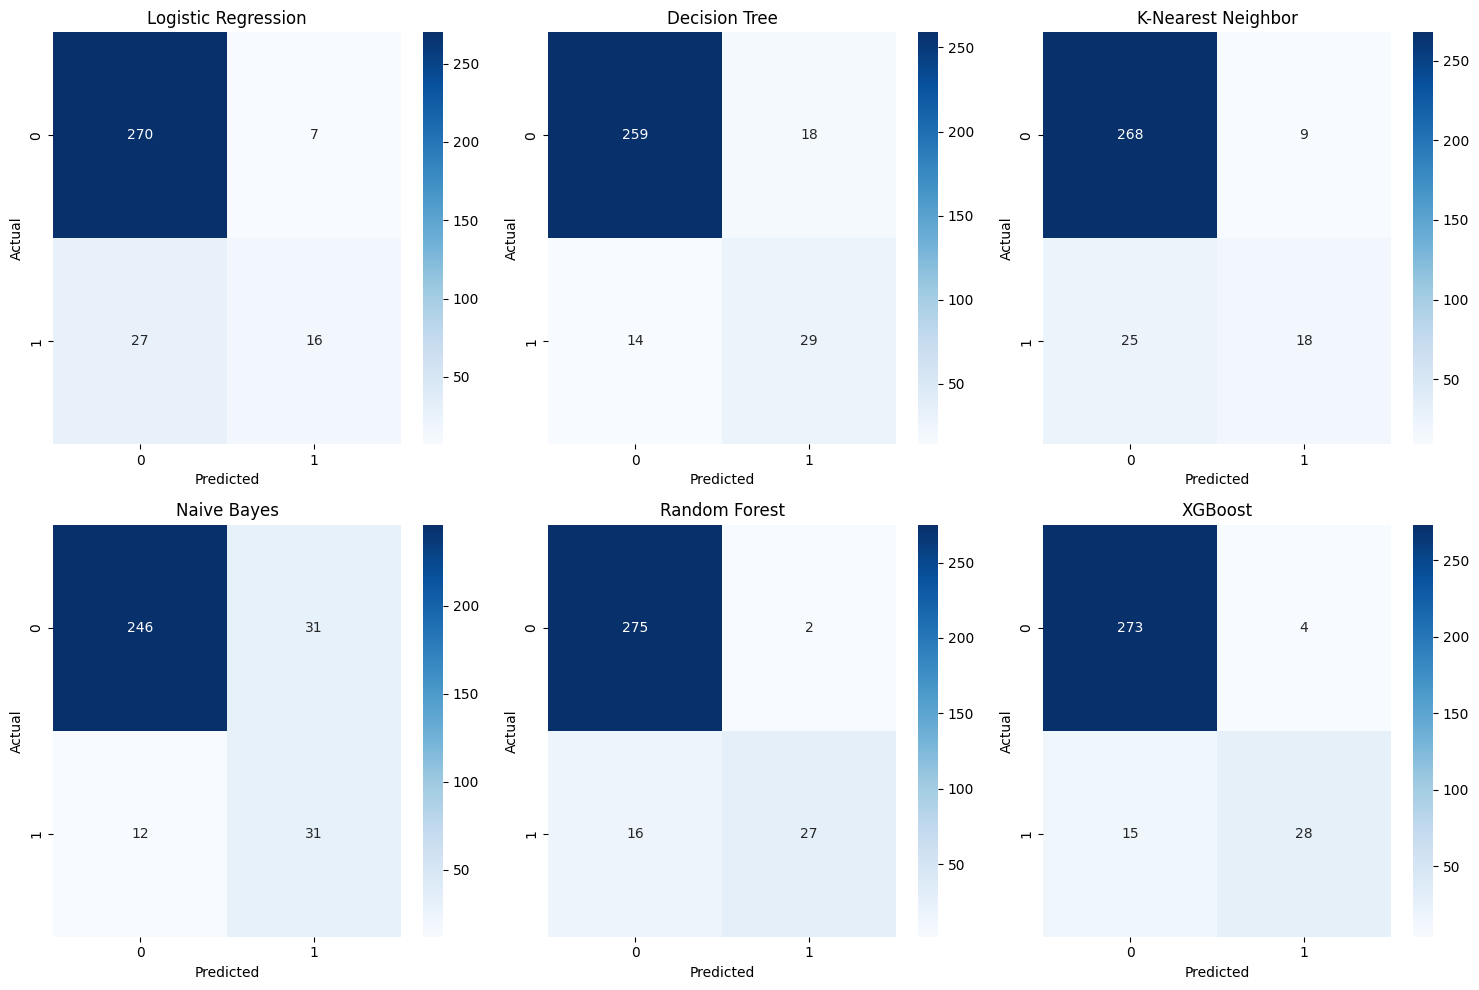

In [23]:
# ============ Confusion matrix plot ============
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(trained_models.items()):
    if name in ['Logistic Regression', 'K-Nearest Neighbor']:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()